In [3]:
import chardet

# Detect the character encoding of the CSV file
with open('twitter_training.csv', 'rb') as file:
    print(chardet.detect(file.read()))  # prints the detected encoding and confidence

{'encoding': 'MacRoman', 'confidence': 0.7062714576015133, 'language': ''}


In [4]:
import pandas as pd
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
import re

c:\Users\richa\anaconda3\envs\daps-final\lib\site-packages\torchtext\data\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\richa\anaconda3\envs\daps-final\lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\richa\anaconda3\envs\daps-final\lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WA

In [5]:
# Define a dictionary of contractions and their expanded forms
contractions_dict = {
    "i'm": "I am",
    "i'll": "I will",
    "you're": "you are",
    "he's": "he is",
    "she's": "she is",
    "it's": "it is",
    "we're": "we are",
    "they're": "they are",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "won't": "will not",
    "wouldn't": "would not",
    "don't": "do not",
    "doesn't": "does not",
    "didn't": "did not",
    "can't": "cannot",
    "couldn't": "could not",
    "shouldn't": "should not",
    "mightn't": "might not",
    "mustn't": "must not",
    "b.s.": "because"

}

# Function to replace contractions in a string with all lowercase letters
def expand_contractions(text, contractions_dict):
    # Regular expression for finding contractions
    contractions_re = re.compile('(%s)' % '|'.join(map(re.escape, contractions_dict.keys())))
    
    def replace(match):
        return contractions_dict[match.group(0)]
    
    return contractions_re.sub(replace, text)

In [19]:

# Load dataset
data = pd.read_csv('data_preprocess/twitter_training.csv', encoding='mac_roman')  #Ensure the correct encoding is specified
column_names = ['ID', 'entity', 'sentiment', 'TEXT']

# Set the column names to the DataFrame
data.columns = column_names
# Clean the text
data['TEXT'] = data['TEXT'].str.lower().apply(lambda x: expand_contractions(x, contractions_dict))
data['TEXT'] = data['TEXT'].str.replace(r'[^a-zA-Z0-9\s\.]', '',regex=True)
#print(data['TEXT'][0])
docs= data['TEXT'].apply(lambda x: split_text_into_sentence(x))

FileNotFoundError: [Errno 2] No such file or directory: 'data_preprocess/twitter_training.csv'

In [18]:
data.iloc[:,2]

0        Positive
1        Positive
2        Positive
3        Positive
4        Positive
           ...   
74676    Positive
74677    Positive
74678    Positive
74679    Positive
74680    Positive
Name: Positive, Length: 74681, dtype: object

In [4]:
data['TEXT'] = data['TEXT'].str.lower().apply(lambda x: expand_contractions(x, contractions_dict))

In [13]:
docs = data.iloc[:,3]

In [14]:
docs = docs.str.replace(r'[^a-zA-Z0-9\s\.]', '', regex=True)

In [15]:
docs

0        I am coming to the borders and I will kill you...
1        im getting on borderlands and i will kill you all
2        im coming on borderlands and i will murder you...
3        im getting on borderlands 2 and i will murder ...
4        im getting into borderlands and i can murder y...
                               ...                        
74676    Just realized that the Windows partition of my...
74677    Just realized that my Mac window partition is ...
74678    Just realized the windows partition of my Mac ...
74679    Just realized between the windows partition of...
74680    Just like the windows partition of my Mac is l...
Name: im getting on borderlands and i will murder you all ,, Length: 74681, dtype: object

In [23]:
import spacy

nlp = spacy.load('en_core_web_sm')

for doc in data['TEXT']:
    doc = nlp(doc)
    lemmatized_tokens = [token.lemma_ for token in doc]
    #print("Lemmatized Tokens:", lemmatized_tokens)
    
    data['PROCESSED_TEXT'] = " ".join([token for token in lemmatized_tokens])
    #print("Original Text:", doc)
    

In [24]:
data['PROCESSED_TEXT']

0       I have just get off the phone with brady . I b...
1       I have just get off the phone with brady . I b...
2       I have just get off the phone with brady . I b...
3       I have just get off the phone with brady . I b...
4       I have just get off the phone with brady . I b...
                              ...                        
2462    I have just get off the phone with brady . I b...
2463    I have just get off the phone with brady . I b...
2464    I have just get off the phone with brady . I b...
2465    I have just get off the phone with brady . I b...
2466    I have just get off the phone with brady . I b...
Name: PROCESSED_TEXT, Length: 2467, dtype: object

In [8]:
import re

def preprocess_text(text):
    # Normalize the text by converting to lowercase and removing unwanted characters
    #normalized_text = re.sub(r'[^a-zA-Z0-9!\'\"]', ' ', text.lower())
    
    # Split the text into sentences using periods and question marks
    sentences = re.split(r'[.\n]', text)
    
    # Process each sentence
    processed_sentences = []
    for sentence in sentences:
        words = sentence.split()
        # Check if the sentence is longer than 100 words
        if len(words) > 100:
            # Split the long sentence into smaller chunks of 20 words each
            for i in range(0, len(words), 20):
                chunk = words[i:i+10]
                processed_sentences.append(' '.join(chunk))
        elif len(words) > 1:
            processed_sentences.append(' '.join(words))
    
    return processed_sentences

# Example usage
example_text = ("This is a sentence. Here is another one? Some essays in the dataset "
                "contained no periods or missing periods, resulting in absurdly long "
                "sentences. For these cases, we split each obtained 'sentence' that was "
                "longer than 150 words into 'sentences' of 20 words each.")

processed_text = preprocess_text(data['TEXT'][1])
for sentence in processed_text:
    print(sentence)

well here we go with the stream of consciousness essay
i used to do things like this in high school sometimes
they were pretty interesting but i often find myself with a lack of things to say
i normally consider myself someone who gets straight to the point
i wonder if i should hit enter any time to send this back to the front
maybe I will fix it later
my friend is playing guitar in my room now
sort of playing anyway
more like messing with it
he is still learning
theres a drawing on the wall next to me
comic book characters i think but I am not sure who they are
it is been a while since ive kept up with comics
i just heard a sound from icq
thats a chat program on the internet
i do not know too much about it so i cannot really explain too well
anyway i hope I am done with this by the time another friend comes over
it will be nice to talk to her again
she went home this weekend for labor day
so did my brother
i did not go
I am not sure why
no reason to go i guess
when did i start this
wo

In [9]:
data['PROCESSED_TEXT'] = data['TEXT'].apply(preprocess_text)

In [34]:
data['TEXT'] = data['TEXT'].apply(preprocess_text)

In [10]:
data['PROCESSED_TEXT'][0]

['well right now i just woke up from a midday nap',
 'it is sort of weird but ever since i moved to texas i have had problems concentrating on things',
 'i remember starting my homework in 10th grade as soon as the clock struck 4 and not stopping until it was done',
 'of course it was easier but i still did it',
 'but when i moved here the homework got a little more challenging and there was a lot more busy work and so i decided not to spend hours doing it and just getting by',
 'but the thing was that i always paid attention in class and just plain out knew the stuff and now that i look back if i had really worked hard and stayed on track the last two years without getting lazy i would have been a genius but hey thats all good',
 'it is too late to correct the past but i do not really know how to stay focused n the future',
 'the one thing i know is that when people say that bc they live on campus they cannot concentrate it is b',
 'for me it would be easier there but alas I am living

In [28]:
data['TEXT'] = data['TEXT'].str.lower().str.replace('[^\w\s]', '', regex=True)

In [11]:
# Tokenization
tokenizer = get_tokenizer('basic_english')
tokenized_texts = [[tokenizer(text) for text in sentence]for sentence in data['PROCESSED_TEXT']]

In [13]:
len(tokenized_texts)

2467

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [15]:
import spacy

# Load the English NLP model
nlp = spacy.load("en_core_web_sm")

# Example text
text = "The cats are running faster than the dogs."

# Process the text with spaCy
doc = nlp(text)

# Extract lemmatized forms of the words
lemmatized_tokens = [token.lemma_ for token in doc]

print("Lemmatized Tokens:", lemmatized_tokens)

Lemmatized Tokens: ['the', 'cat', 'be', 'run', 'fast', 'than', 'the', 'dog', '.']


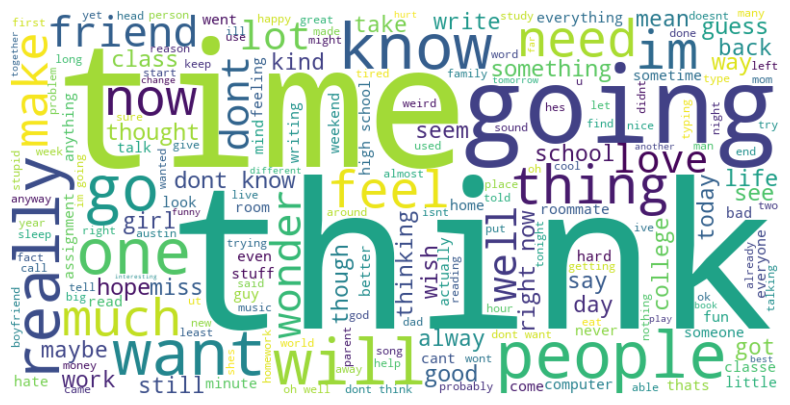

In [48]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Flatten the list of lists into a single string
words = ' '.join([' '.join(sublist) for sublist in tokenized_texts])
# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

In [32]:
from gensim.models import KeyedVectors
import numpy as np
#Step 1: Build vocabulary
vocab = {}
index = 1  # Start indexing from 1 since 0 is often used for padding
for tokens in tokenized_texts:
    for token in tokens:
        if token not in vocab:
            vocab[token] = index
            index += 1

# Step 2: Convert tokens to indices
token_indices = [[vocab[token] for token in tokens] for tokens in tokenized_texts]

w2v_file =  "GoogleNews-vectors-negative300.bin" # Path to Word2Vec file
w2v = KeyedVectors.load_word2vec_format(w2v_file, binary=True)
embedding_dim = w2v.vector_size

# Add Word2Vec and Unknown Words
W = np.zeros((len(vocab) + 1, embedding_dim))
for word, i in vocab.items():
    if word in w2v:
        W[i] = w2v[word]
    else:
        W[i] = np.random.uniform(-0.25, 0.25, embedding_dim)


# Step 3: Padding sequences
max_length = max(len(tokens) for tokens in token_indices)
padded_texts = [tokens + [0] * (max_length - len(tokens)) for tokens in token_indices]


In [26]:
W[0]

NameError: name 'W' is not defined

In [77]:
# Convert to PyTorch tensors
padded_texts_tensor = torch.tensor(padded_texts)

In [80]:
padded_texts_tensor.shape

torch.Size([2467, 2499])

In [33]:
# Convert personality trait labels to a tensor
labels = data[['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']].replace({'y': 1, 'n': 0}).values
labels_tensor = torch.tensor(labels, dtype=torch.float32)


In [34]:
from sklearn.model_selection import train_test_split
# Step 4: Split the data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(padded_texts_tensor, labels_tensor, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [35]:
from torch.utils.data import DataLoader, Dataset
# Define the dataset class
class EssayDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [36]:
# Create DataLoaders
train_dataset = EssayDataset(X_train, y_train)
val_dataset = EssayDataset(X_val, y_val)
test_dataset = EssayDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [37]:
len(train_dataset[0][0])


2499

In [41]:
from torch import nn, optim
import numpy as np
from sklearn.metrics import accuracy_score
# Step 5: Define the model
# Model class
class EssayLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_lstm_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Initialize embedding with pre-trained word vectors
        self.embedding.weight.data.copy_(torch.from_numpy(W))
        
        # Multiple layers of LSTM
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_lstm_layers, batch_first=True)
        
        # An additional fully connected layer for deeper processing
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        # Optional: Dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, text):
        embedded = self.embedding(text)
        _, (hidden, _) = self.lstm(embedded)
        
        # Process the last hidden state of the last LSTM layer
        out = self.dropout(hidden[-1])
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        
        return out
# Instantiate the model
vocab_size = len(vocab) + 1  # +1 for padding index 0
embedding_dim = W.shape[1]  # Assuming W is the embedding matrix loaded earlier
hidden_dim = 50
output_dim = 5  # Number of personality traits

model = EssayLSTM(vocab_size, embedding_dim, hidden_dim, output_dim)

# Loss function and optimizer
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())

# Step 6: Train the model with validation
epochs = 10
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for texts, labels in train_loader:
        optimizer.zero_grad()
        predictions = model(texts)
        loss = loss_function(predictions, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    print(f'Epoch {epoch + 1}, Training Loss: {total_train_loss / len(train_loader)}')

    # Validation step
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for texts, labels in val_loader:
            predictions = model(texts)
            loss = loss_function(predictions, labels)
            total_val_loss += loss.item()
        print(f'Epoch {epoch + 1}, Validation Loss: {total_val_loss / len(val_loader)}')

# Step 7: Evaluate the model on the test set and compute accuracy for each trait
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for texts, labels in test_loader:
        predictions = model(texts)
        predictions = torch.sigmoid(predictions).round()  # Convert to binary predictions
        y_pred.extend(predictions.numpy())
        y_true.extend(labels.numpy())

# Calculate accuracy for each trait
y_pred = np.array(y_pred)
y_true = np.array(y_true)
trait_names = ['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']
for i, trait in enumerate(trait_names):
    trait_accuracy = accuracy_score(y_true[:, i], y_pred[:, i])
    print(f'Accuracy for {trait}: {trait_accuracy:.4f}')

Epoch 1, Training Loss: 0.6933947691210994
Epoch 1, Validation Loss: 0.6921726614236832
Epoch 2, Training Loss: 0.6931668784883287
Epoch 2, Validation Loss: 0.6926493048667908
Epoch 3, Training Loss: 0.6928856129999514
Epoch 3, Validation Loss: 0.6923019041617712
Epoch 4, Training Loss: 0.6928575248629959
Epoch 4, Validation Loss: 0.6921174575885137
Epoch 5, Training Loss: 0.6930599047078027
Epoch 5, Validation Loss: 0.6920560548702875
Epoch 6, Training Loss: 0.693088948726654
Epoch 6, Validation Loss: 0.6924251765012741
Epoch 7, Training Loss: 0.6928766877562912
Epoch 7, Validation Loss: 0.6923599044481913
Epoch 8, Training Loss: 0.6927148699760437
Epoch 8, Validation Loss: 0.692187120517095
Epoch 9, Training Loss: 0.6928292733651621
Epoch 9, Validation Loss: 0.6922002534071604
Epoch 10, Training Loss: 0.6931030982070499
Epoch 10, Validation Loss: 0.692452092965444
Accuracy for cEXT: 0.5687
Accuracy for cNEU: 0.5040
Accuracy for cAGR: 0.5310
Accuracy for cCON: 0.5553
Accuracy for cOPN

In [24]:
len(padded_texts[2])
#longest_sublist = max(tokenized_texts, key=len)

2499

In [21]:
print("The sublist with the most elements is:", longest_sublist, "length is ", len(longest_sublist))

The sublist with the most elements is: ['im', 'thinking', 'about', 'what', 'i', 'need', 'to', 'do', 'before', 'classes', 'start', 'again', 'but', 'every', 'time', 'i', 'get', 'started', 'something', 'interrupts', 'me', 'or', 'i', 'just', 'dont', 'feel', 'like', 'doing', 'it', 'im', 'sitting', 'in', 'my', 'room', 'in', 'front', 'of', 'my', 'awesome', 'new', 'computer', 'listening', 'to', 'the', 'wicked', 'soundtrack', 'its', 'amazing', 'my', 'room', 'smelled', 'before', 'but', 'i', 'cleaned', 'the', 'kitchen', 'so', 'now', 'it', 'doesnt', 'smell', 'anymore', 'stacy', 'just', 'walked', 'in', 'my', 'room', 'and', 'i', 'yelled', 'at', 'her', 'because', 'i', 'am', 'not', 'supposed', 'to', 'be', 'disturbed', 'during', 'my', 'writing', 'assignments', 'im', 'feeling', 'kind', 'of', 'gross', 'actually', 'i', 'feel', 'gross', 'because', 'its', 'the', 'end', 'of', 'the', 'weekend', 'and', 'i', 'was', 'out', 'partying', 'the', 'whole', 'time', 'i', 'hate', 'when', 'people', 'are', 'like', 'yeah', 

In [95]:
# Build vocabulary
vocab = build_vocab_from_iterator(tokenized_texts, specials=['<unk>', '<pad>'])
vocab.set_default_index(vocab['<unk>']) 

In [96]:
# Convert texts to tensor of token ids
text_pipeline = lambda x: vocab(tokenizer(x))
numericalized_texts = [torch.tensor(text_pipeline(text)) for text in data['TEXT']]


In [97]:
numericalized_texts

[tensor([   66,    73,    42,     2,    22,   968,    50,    74,     8, 13904,
           792,    40,   491,    10,   235,    14,   174,   156,     2,   660,
             3,   468,     2,    13,    75,   479,  2571,    27,    81,     2,
           314,   391,     6,   274,    12,  3961,   467,    57,   331,    57,
             4,   705,  5150,   456,     5,    25,  1943,   267,    11,    26,
           172,    10,   383,    11,    26,   552,    14,     2,   114,   143,
            11,    14,    56,     2,   660,    71,     4,   274,   115,     8,
           130,    72,  2697,     5,    65,    26,     8,    98,    72,   625,
           129,     5,    16,     2,   540,    25,     3,   482,   324,   122,
            11,     5,    22,   162,   118,    14,     4,   112,    26,     7,
             2,    99,  1032,   666,    12,    84,     5,    22,  1939,    48,
           356,     4,   192,     5,    42,     7,     2,   223,    94,    43,
             2,    75,    24,   690,   139,     5,  

In [43]:
# Pad sequences
padded_sequences = pad_sequence(numericalized_texts, batch_first=True, padding_value=vocab['<pad>'])

# Convert categorical labels from 'y'/'n' to 1/0
label_columns = ['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']
data[label_columns] = data[label_columns].applymap(lambda x: 1 if x == 'y' else 0)

# Labels (assuming binary labels for simplicity)
labels = torch.tensor(data[label_columns].values, dtype=torch.float)

print(padded_sequences.shape)
print(labels.shape)

torch.Size([2467, 2499])
torch.Size([2467, 5])


Function

In [81]:
text_list = data['TEXT']

In [84]:
text_list[0]

'well here we go with the stream of consciousness essay i used to do things like this in high school sometimes they were pretty interesting but i often find myself with a lack of things to say i normally consider myself someone who gets straight to the point i wonder if i should hit enter any time to send this back to the front maybe ill fix it later my friend is playing guitar in my room now sort of playing anyway more like messing with it hes still learning theres a drawing on the wall next to me comic book characters i think but im not sure who they are its been a while since ive kept up with comics i just heard a sound from icq thats a chat program on the internet i dont know too much about it so i cant really explain too well anyway i hope im done with this by the time another friend comes over it will be nice to talk to her again she went home this weekend for labor day so did my brother i didnt go im not sure why no reason to go i guess hmm when did i start this wow that was a l

In [82]:
# Pad sequences to the same length
padded_sequences = torch.nn.utils.rnn.pad_sequence(text_list, batch_first=True, padding_value=0)

TypeError: expected Tensor as element 0 in argument 0, but got str

In [87]:
from transformers import pipeline

# Load the sentiment analysis model
sentiment_analyzer = pipeline("sentiment-analysis")

def analyze_sentiment_average(text):
    if isinstance(text, str):
        # Split the text into words
        tokenized_text = text.split()
        chunks = []

        # Create chunks of up to 512 tokens
        for i in range(0, len(tokenized_text), 512):
            chunk = tokenized_text[i:i+512]
            if chunk:
                chunks.append(" ".join(chunk))

        # Analyze sentiment for each chunk
        sentiments = []
        for chunk in chunks:
            try:
                result = sentiment_analyzer(chunk)[0]
                sentiments.append(result)
            except Exception as e:
                print(f"An error occurred while analyzing chunk: {e}")
                continue

        # Calculate the average sentiment
        if sentiments:
            score = sum(s['score'] for s in sentiments) / len(sentiments)
            labels = [s['label'] for s in sentiments]
            label = max(set(labels), key=labels.count)
            return {'label': label, 'score': score}
    return {'label': 'neutral', 'score': 0}



# Apply the sentiment analysis function
data['sentiment'] = data['TEXT'].apply(analyze_sentiment_average)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/Users/zarius/miniconda3/envs/daps-final/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (534 > 512). Running this sequence through the model will result in indexing errors


An error occurred while analyzing chunk: The size of tensor a (534) must match the size of tensor b (512) at non-singleton dimension 1
An error occurred while analyzing chunk: The size of tensor a (538) must match the size of tensor b (512) at non-singleton dimension 1
An error occurred while analyzing chunk: The size of tensor a (575) must match the size of tensor b (512) at non-singleton dimension 1
An error occurred while analyzing chunk: The size of tensor a (561) must match the size of tensor b (512) at non-singleton dimension 1
An error occurred while analyzing chunk: The size of tensor a (553) must match the size of tensor b (512) at non-singleton dimension 1
An error occurred while analyzing chunk: The size of tensor a (534) must match the size of tensor b (512) at non-singleton dimension 1
An error occurred while analyzing chunk: The size of tensor a (543) must match the size of tensor b (512) at non-singleton dimension 1
An error occurred while analyzing chunk: The size of te

In [80]:
def analyze_sentiment_average(text):
    # Split text into chunks of 512 tokens each
    if isinstance(text, str):
        tokenized_text = text.split()
        chunks = [tokenized_text[i:i + 512] for i in range(0, len(tokenized_text), 512)]
        sentiments = [sentiment_analyzer(" ".join(chunk))[0] for chunk in chunks]

        # Calculate the average sentiment
        if sentiments:
            score = sum(s['score'] for s in sentiments) / len(sentiments)
            # Choosing the most frequent label as the final label
            labels = [s['label'] for s in sentiments]
            label = max(set(labels), key=labels.count)
            return {'label': label, 'score': score}
    return {'label': 'neutral', 'score': 0}

# Apply the sentiment analysis function
data['sentiment'] = data['TEXT'].apply(analyze_sentiment_average)

RuntimeError: The size of tensor a (534) must match the size of tensor b (512) at non-singleton dimension 1

In [57]:
from transformers import pipeline

classifier = pipeline(model="FacebookAI/roberta-large-mnli")
preds = classifier(data['TEXT'][0])
preds = [{"score": round(pred["score"], 4), "label": pred["label"]} for pred in preds]
preds
[{'score': 0.9991, 'label': 'POSITIVE'}]

Some weights of the model checkpoint at FacebookAI/roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


AttributeError: module 'requests' has no attribute 'exceptions'

In [58]:
from transformers import pipeline

# Load a pre-trained sentiment analysis model
sentiment_analyzer = pipeline(task="sentiment-analysis")

preds = sentiment_analyzer(data['TEXT'][0])

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Token indices sequence length is longer than the specified maximum sequence length for this model (689 > 512). Running this sequence through the model will result in indexing errors


RuntimeError: The size of tensor a (689) must match the size of tensor b (512) at non-singleton dimension 1

In [ ]:
# Apply the model to each text entry
data['sentiment'] = data['TEXT'].apply(lambda x: sentiment_analyzer(x)[0])

# Print out the first few sentiment analysis results to check
print(data['sentiment'].head())

In [37]:
len(tokenized_texts[1])

646

In [20]:



# Text cleaning
# Ensure to handle NaN values and perform more controlled cleaning
data['essay'] = data['essay'].fillna('')  # Replace NaN with empty strings
data['TEXT'] = data['TEXT'].str.lower().str.replace('[^\w\s]', '', regex=True)

# Tokenization
tokenizer = get_tokenizer('basic_english')
tokenized_texts = [tokenizer(essay) for essay in data['essay'] if isinstance(essay, str)]  # Ensure that each essay is a string

# Build vocabulary
vocab = build_vocab_from_iterator(tokenized_texts, specials=['<unk>', '<pad>'])
vocab.set_default_index(vocab['<unk>'])  # Set '<unk>' as the default index for unknown tokens

# Convert texts to tensor of token ids
text_pipeline = lambda x: vocab(tokenizer(x))
numericalized_texts = [torch.tensor(text_pipeline(text)) for text in data['essay']]

# Pad sequences
padded_sequences = pad_sequence(numericalized_texts, batch_first=True, padding_value=vocab['<pad>'])

# Labels (assuming binary labels for simplicity)
labels = torch.tensor(data[['trait1', 'trait2', 'trait3', 'trait4', 'trait5']].values, dtype=torch.float)  # Specify dtype explicitly

print(padded_sequences.shape)
print(labels.shape)


KeyError: 'essay'

In [3]:
import pandas as pd
data = pd.read_csv('essays.csv', encoding='mac_roman') 
raw_texts = data['TEXT'].tolist()

In [10]:
raw_texts[0]

'Well, right now I just woke up from a mid-day nap. It\'s sort of weird, but ever since I moved to Texas, I have had problems concentrating on things. I remember starting my homework in  10th grade as soon as the clock struck 4 and not stopping until it was done. Of course it was easier, but I still did it. But when I moved here, the homework got a little more challenging and there was a lot more busy work, and so I decided not to spend hours doing it, and just getting by. But the thing was that I always paid attention in class and just plain out knew the stuff, and now that I look back, if I had really worked hard and stayed on track the last two years without getting  lazy, I would have been a genius, but hey, that\'s all good. It\'s too late to correct the past, but I don\'t really know how to stay focused n the future. The one thing I know is that when  people say that b/c they live on campus they can\'t concentrate, it\'s b. s. For me it would be easier there, but alas, I\'m livin

In [11]:
data[['cEXT']].replace({'y': 1, 'n': 0}).values[0:10]

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [20]:
import pandas as pd
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from wordcloud import WordCloud
from gensim.models import KeyedVectors
from torch.utils.data import Dataset, random_split
from transformers import BertTokenizer
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Define a dictionary of contractions and their expanded forms
contractions_dict = {
    "i'm": "I am",
    "i'll": "I will",
    "you're": "you are",
    "he's": "he is",
    "she's": "she is",
    "it's": "it is",
    "we're": "we are",
    "they're": "they are",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "won't": "will not",
    "wouldn't": "would not",
    "don't": "do not",
    "doesn't": "does not",
    "didn't": "did not",
    "can't": "cannot",
    "couldn't": "could not",
    "shouldn't": "should not",
    "mightn't": "might not",
    "mustn't": "must not"

}

# Function to replace contractions in a string with all lowercase letters
def expand_contractions(text, contractions_dict):
    # Regular expression for finding contractions
    contractions_re = re.compile('(%s)' % '|'.join(map(re.escape, contractions_dict.keys())))
    
    def replace(match):
        return contractions_dict[match.group(0)]
    
    return contractions_re.sub(replace, text)

def split_text_into_sentence1(text):
    # Remove all characters that are not alphanumeric or spaces
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Split using period followed by whitespace or end of text to denote sentence boundaries
    sentences = re.split(r'\.\s+|\.$', cleaned_text)
    
    # Join all sentences into one single text
    all_words = []
    for sentence in sentences:
        words = sentence.split()
        if words:  # Check if the sentence is not empty
            all_words.extend(words)
    
    # Now split all_words into chunks of 50 words each
    processed_sentences = []
    for i in range(0, len(all_words), 50):
        chunk = all_words[i:i + 50]
        # Convert chunk of words back into a single sentence string
        if chunk:  # Ensure the chunk is not empty
            processed_sentences.append(' '.join(chunk))
    
    return processed_sentences

def split_text_into_sentence(text):
    # Split using period followed by whitespace or end of text to denote sentence boundaries
    sentences = re.split(r'\.\s+|\.$', text)
    
    # Process each sentence to handle long sentences, remove empty sentences, and skip short sentences
    processed_sentences = []
    for sentence in sentences:
        words = sentence.split()
        # Skip any empty sentences or sentences shorter than 10 words
        if len(words) < 20:
            continue
        
        # If the sentence is longer than 100 words, chunk it into parts of 50 words each
        if len(words) > 100:
            for i in range(0, len(words), 50):
                chunk = words[i:i + 50]
                # Ensure the chunk is not empty and meets the minimum word count
                if len(chunk) >= 20:
                    processed_sentences.append(' '.join(chunk))
        else:
            # Add the sentence if it meets the minimum word count
            joined_sentence = ' '.join(words)
            if joined_sentence:
                processed_sentences.append(joined_sentence)
    
    return processed_sentences

def convert_tokens_to_indices(documents, vocab):
    max_sentences = max(len(doc) for doc in documents)
    max_len = max(len(sentence) for doc in documents for sentence in doc)

    indexed_documents = []
    for doc in documents:
        indexed_sentences = []
        for sentence in doc:
            indexed_sentence = [vocab[token] for token in sentence]
            # Pad each sentence to max_len
            indexed_sentence += [vocab["<pad>"]] * (max_len - len(indexed_sentence))
            indexed_sentences.append(indexed_sentence)
        # Pad the number of sentences in each document
        while len(indexed_sentences) < max_sentences:
            indexed_sentences.append([vocab["<pad>"]] * max_len)
        indexed_documents.append(indexed_sentences)

    indexed_documents_tensor = torch.tensor(indexed_documents)
    return indexed_documents_tensor

def apply_word_embeddings(vocab):
    # Load the pre-trained Word2Vec model
    word2vec = KeyedVectors.load_word2vec_format('data_preprocess/GoogleNews-vectors-negative300.bin', binary=True)
    embedding_dim = word2vec.vector_size  # Typically 300 for Google's Word2Vec

    # Initialize the embedding matrix
    embedding_matrix = np.zeros((len(vocab), embedding_dim))

    for word, idx in vocab.get_stoi().items():
        if word in word2vec:
            embedding_matrix[idx] = word2vec[word]
        else:
            # Initialize with a random vector
            embedding_matrix[idx] = np.random.uniform(-0.25, 0.25, embedding_dim)

    # Convert the embedding matrix to a tensor
    embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
    return embedding_matrix

def yield_tokens(data):
    for document in data:
        for sentence in document:
            yield sentence

class EssaysDataset(Dataset):
    def __init__(self, documents, labels):
        self.documents = documents
        self.labels = labels
    
    def __len__(self):
        return len(self.documents)
    
    def __getitem__(self, idx):
        return torch.tensor(self.documents[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float32)


c:\Users\richa\anaconda3\envs\daps-final\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
data = pd.read_csv('twitter_training.csv', encoding='mac_roman')  #Ensure the correct encoding is specified
column_names = ['ID', 'entity', 'sentiment', 'TEXT']

# Set the column names to the DataFrame
data.columns = column_names


In [32]:
type(data['TEXT'][20])

str

In [33]:
# Clean the text
data['TEXT'] = data['TEXT'].str.lower()
#data['TEXT'] = data['TEXT'].str.lower().apply(lambda x: expand_contractions(x, contractions_dict))
data['TEXT'] = data['TEXT'].str.replace(r'[^a-zA-Z0-9\s\.]', '',regex=True)
#print(data['TEXT'][0])
data['TEXT'] = data['TEXT'].astype(str)

docs= data['TEXT'].apply(lambda x: split_text_into_sentence(x))

# Tokenization
tokenizer = get_tokenizer('basic_english')
tokenized_texts = [[tokenizer(text) for text in sentence]for sentence in docs]

In [5]:
import numpy as np

correct = np.array([[False, False, False, False, False],
                    [False, True, False, True, True],
                    [True, False, False, True, True],
                    [False, True, False, False, True],
                    [False, True, True, True, True],
                    [True, False, True, True, True],
                    [False, True, True, True, False],
                    [False, False, True, False, False],
                    [True, True, True, True, False],
                    [True, False, False, True, False],
                    [True, False, False, True, True],
                    [False, False, True, True, False],
                    [True, True, False, True, False],
                    [True, False, True, False, True],
                    [False, True, True, True, True],
                    [False, True, False, False, False]])

# Calculate the number of True values in each column
true_counts_per_column = correct.sum(axis=0)
total_counts_per_colum  = correct.shape[0]
print("Number of True values in each column:", true_counts_per_column, "\nTotal counts per column:", total_counts_per_colum)

Number of True values in each column: [ 7  8  8 11  8] 
Total counts per column: 16


In [15]:
true_counts_per_column = true_counts_per_column +np.array([ 7 ,8,8,11, 8])

In [16]:
true_counts_per_column

array([21, 24, 24, 33, 24])

In [6]:
accuracy = true_counts_per_column / total_counts_per_colum